In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import cv2 as cv
import random
import shutil
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/yolo_hand_detection/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d innominate817/hagrid-sample-120k-384p

100% 3.08G/3.08G [01:58<00:00, 37.0MB/s]
100% 3.08G/3.08G [01:58<00:00, 27.9MB/s]


In [5]:
!unzip /content/hagrid-sample-120k-384p.zip > /dev/null 2>&1
!rm /content/hagrid-sample-120k-384p.zip

In [6]:
data_dir = '/content/hagrid-sample-120k-384p'
annotations_dir = os.path.join(data_dir, 'ann_train_val')
images_dir = os.path.join(data_dir, 'hagrid_120k')
classes = ['two_up', 'one', 'dislike', 'like', 'mute','ok','fist','palm','peace','stop']
image_ext = 'jpg'

In [7]:
for file in os.listdir(annotations_dir):
  _class = file.split('.')[0]
  if _class not in classes:
    os.remove(os.path.join(annotations_dir, file))
    shutil.rmtree(os.path.join(images_dir, f'train_val_{_class}'))

In [8]:
class GenerateDataset:
  def __init__(self, annotation_path, image_ext):
    self.annotation_path = annotation_path
    self.image_ext = image_ext
    self.dataframe = None

  def generate(self):
    if not os.path.exists(self.annotation_path):
      print('Annotations does not exist')
      return

    classes = [_class_.split(".")[0] for _class_ in os.listdir(self.annotation_path)]
    count = 0

    for target in classes:
      if not os.path.exists(os.path.join(self.annotation_path, f'{target}.json')):
        print(f'Target: {target} does not exist')
        continue

      json_annotations = json.load(
          open(
              os.path.join(self.annotation_path, f'{target}.json')
          )
      )

      annotations = []

      for name, annotation in zip(json_annotations.keys(), json_annotations.values()):
        no_gesture_index = None
        for index, gesture in enumerate(annotation['labels']):
          if(gesture == 'no_gesture'):
            no_gesture_index = index
            break
        if no_gesture_index is not None:
          annotation['labels'].pop(no_gesture_index)
          annotation['bboxes'].pop(no_gesture_index)

        if len(annotation['bboxes']) > 0:
          annotations.append({ 'filename': name, 'target': target, **annotation })

        if len(annotation['bboxes']) > 1:
          count += 1

      annotations = pd.DataFrame(annotations)
      self.dataframe = pd.concat([self.dataframe, annotations], ignore_index=True)

    data = self.dataframe.copy()
    data['bbox_x'] = data['bboxes'].map(lambda x: x[0][0])
    data['bbox_y'] = data['bboxes'].map(lambda x: x[0][1])
    data['bbox_width'] = data['bboxes'].map(lambda x: x[0][2])
    data['bbox_height'] = data['bboxes'].map(lambda x: x[0][3])
    data = data.sample(frac=1)
    data = data.drop(['leading_conf', 'user_id', 'labels', 'bboxes'], axis=1)

    av_images = []
    for index, row in data.iterrows():
      _class = row['target']
      foldername = f'train_val_{_class}'
      class_path = os.path.join(images_dir, foldername)
      file_path = os.path.join(class_path, row['filename'] + '.jpg')

      if os.path.exists(file_path):
        av_images.append(True)
      else:
        av_images.append(False)

    data = data[av_images]

    return data

In [9]:
raw_data = GenerateDataset(annotations_dir, image_ext).generate()
print(raw_data.shape)
print(raw_data.head())

(70925, 7)
                                    filename   target leading_hand    bbox_x  \
147143  493ea7fe-e7f6-4a07-8b56-6e1007f0e1c7       ok        right  0.313517   
56132   066680a3-ffca-490e-943c-7938580b05f2  dislike        right  0.256123   
190554  46b3ab98-5bf6-446d-8570-5a43a1023c40     fist        right  0.256565   
210121  537aadd0-817e-439e-912e-ce328891bbd4     stop         left  0.626875   
141898  f1527259-5bbb-493a-9f2d-c0731bc12205   two_up         left  0.516539   

          bbox_y  bbox_width  bbox_height  
147143  0.355605    0.148177     0.164455  
56132   0.313048    0.147733     0.161712  
190554  0.262610    0.206531     0.170334  
210121  0.462173    0.121747     0.159045  
141898  0.299225    0.067745     0.192684  


In [10]:
data = raw_data.copy()
data.head()

filename   target leading_hand    bbox_x  \
147143  493ea7fe-e7f6-4a07-8b56-6e1007f0e1c7       ok        right  0.313517   
56132   066680a3-ffca-490e-943c-7938580b05f2  dislike        right  0.256123   
190554  46b3ab98-5bf6-446d-8570-5a43a1023c40     fist        right  0.256565   
210121  537aadd0-817e-439e-912e-ce328891bbd4     stop         left  0.626875   
141898  f1527259-5bbb-493a-9f2d-c0731bc12205   two_up         left  0.516539   

          bbox_y  bbox_width  bbox_height  
147143  0.355605    0.148177     0.164455  
56132   0.313048    0.147733     0.161712  
190554  0.262610    0.206531     0.170334  
210121  0.462173    0.121747     0.159045  
141898  0.299225    0.067745     0.192684

In [11]:
def draw_image_with_bbox(row, image_path, ax=plt):
    # Extract information from the DataFrame row
    _class = row['target']
    class_path = os.path.join(image_path, f'train_val_{_class}')
    file_path = os.path.join(class_path, row['filename'] + '.jpg')
    x_norm, y_norm, width_norm, height_norm = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']

    # Read the image using OpenCV
    img = cv.imread(file_path)
    img_height, img_width, _ = img.shape

    # Extract bbox coordinates and adjust for padding
    x = int(x_norm * img_width)
    y = int(y_norm * img_height)
    width = int(width_norm * img_width)
    height = int(height_norm * img_height)

    # Draw the bounding box on the image
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    x2 = x + width  # Calculate the x-coordinate of the bottom right corner
    y2 = y + height  # Calculate the y-coordinate of the bottom right corner

    img = cv.rectangle(img, (x, y), (x2, y2), (255, 0, 0), 3)

    # Display the image with the bounding box using Matplotlib
    ax.set_title(row['target'])
    ax.imshow(img)
    ax.axis('off')

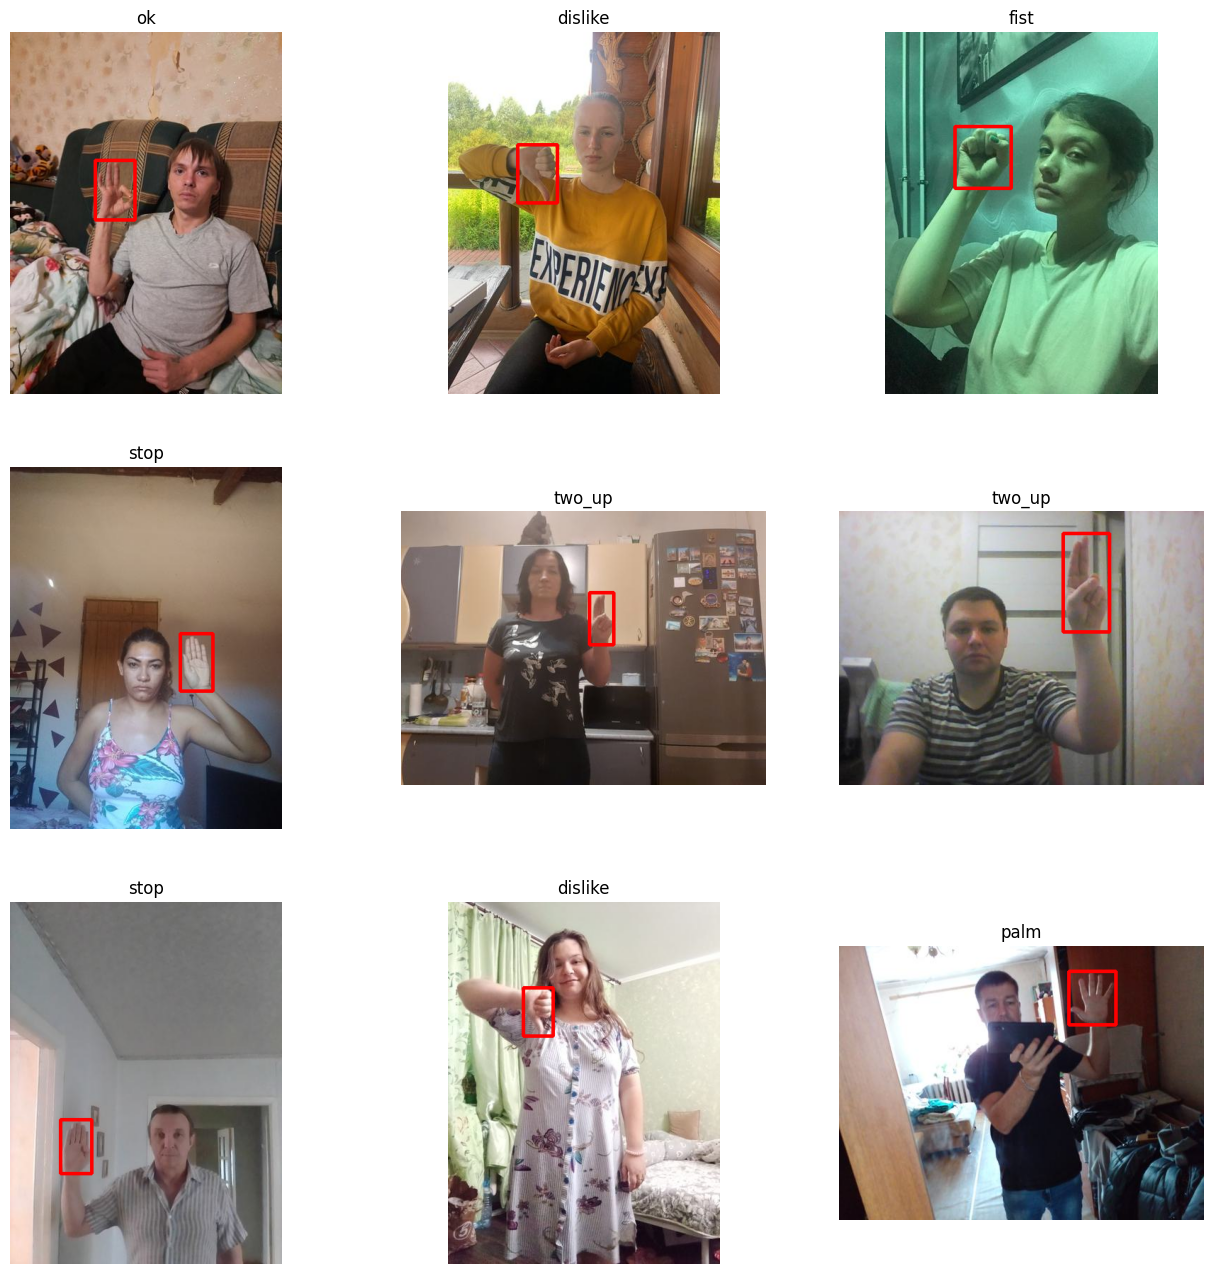

In [12]:
no_of_imgs = 10
imgs_per_row = 3

fig, axes = plt.subplots(no_of_imgs // imgs_per_row, imgs_per_row, figsize=(16,16))
for i, ax in enumerate(axes.ravel()):
  draw_image_with_bbox(data.iloc[i], images_dir, ax)

Category selected: ok
No of items in category: 6999


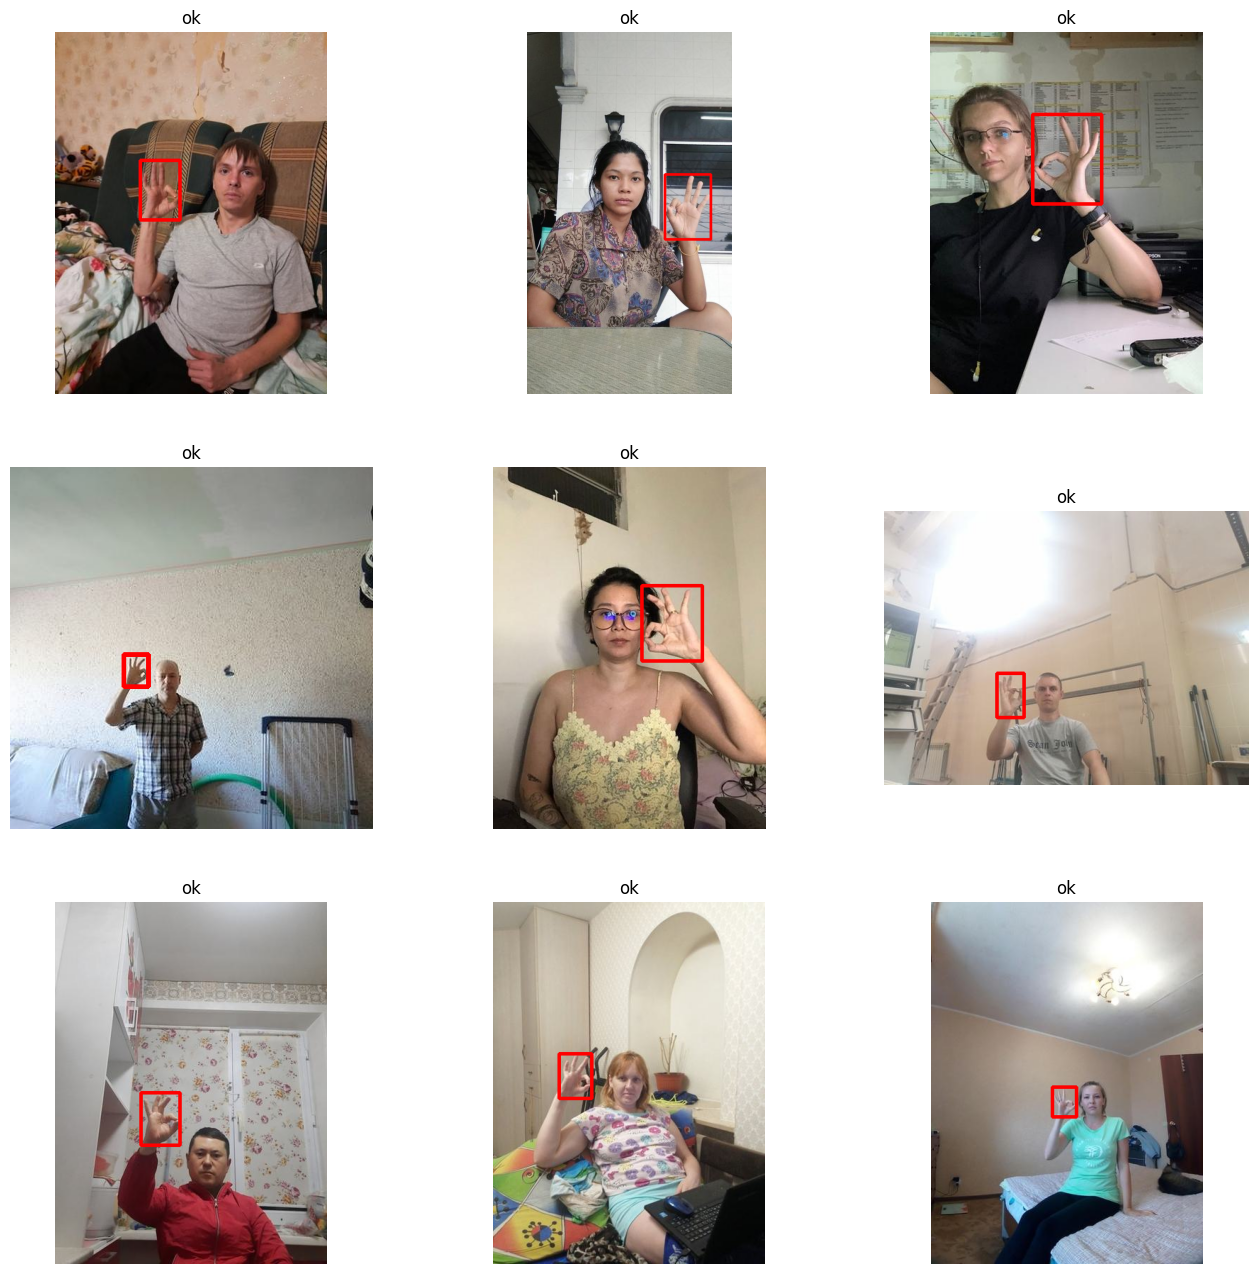

In [13]:
random_gesture = np.random.choice(data['target'].unique())
hand_data = data[data['target'] == random_gesture]

print(f'Category selected: {random_gesture}')
print(f'No of items in category: {len(hand_data)}')

no_of_imgs = 10
imgs_per_row = 3

fig, axes = plt.subplots(no_of_imgs // imgs_per_row, imgs_per_row, figsize=(16,16))
for i, ax in enumerate(axes.ravel()):
  draw_image_with_bbox(hand_data.iloc[i], images_dir, ax)

Category selected: mute
No of items in category: 7243


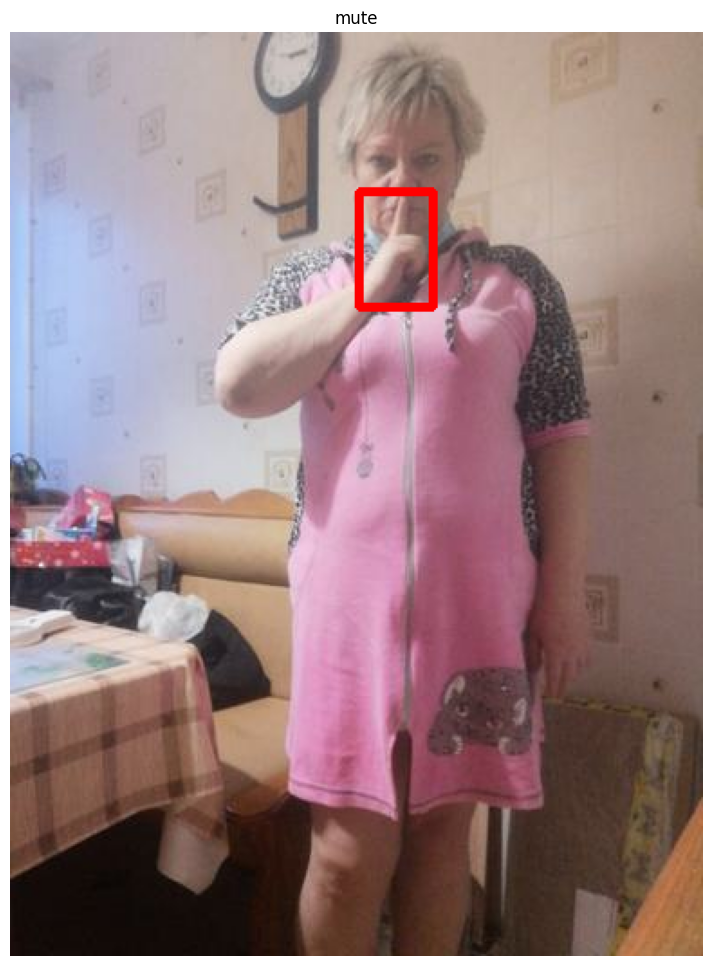

In [14]:
random_gesture = np.random.choice(data['target'].unique())
hand_data = data[data['target'] == random_gesture]

print(f'Category selected: {random_gesture}')
print(f'No of items in category: {len(hand_data)}')

random_image = hand_data.iloc[np.random.randint(low=0, high=len(hand_data))]

fig, axes = plt.subplots(1, 1, figsize=(15,12))
draw_image_with_bbox(random_image, images_dir, axes)

Yolo Detection =>

In [15]:
# starting with yolo directory

!mkdir /content/yolo /content/yolo/images /content/yolo/labels
!mkdir /content/yolo/images/train /content/yolo/images/test /content/yolo/images/val
!mkdir /content/yolo/labels/train /content/yolo/labels/test /content/yolo/labels/val

In [16]:
main, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(main, test_size=0.1, random_state=42)
print(f'Train: {train.shape}')
print(f'Val: {val.shape}')
print(f'Test: {test.shape}')

Train: (57448, 7)
Val: (6384, 7)
Test: (7093, 7)


In [17]:
def create_yolo_format(dataset, image_path, annotation_path):
    for index, row in dataset.iterrows():
        _class = row['target']
        class_path = os.path.join(images_dir, f'train_val_{_class}')
        file_path = os.path.join(class_path, row['filename'] + '.jpg')
        x_norm, y_norm, width_norm, height_norm = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']

        image = cv.imread(file_path)
        img_height, img_width, _ = image.shape

        # Getting actual coordinates
        x = x_norm * img_width
        y = y_norm * img_height
        width = width_norm * img_width
        height = height_norm * img_height

        x2 = x + width  # Calculate the x-coordinate of the bottom right corner
        y2 = y + height  # Calculate the y-coordinate of the bottom right corner

        # Converting to YOLO format:
        x_yolo = (x + x2) / 2
        y_yolo = (y + y2) / 2

        # Normalizing the coordinates
        x_yolo = x_yolo / img_width
        y_yolo = y_yolo / img_height

        # Correctly normalize the width and height
        width_yolo = width / img_width
        height_yolo = height / img_height

        # Copying the image
        dest_image_path = os.path.join(image_path, row['filename'] + '.jpg')
        shutil.copy(file_path, dest_image_path)

        # Creating annotations file for the image
        dest_annotation_path = os.path.join(annotation_path, row['filename'] + '.txt')
        with open(dest_annotation_path, 'w') as file:
            file.write(f"{classes.index(_class)} {x_yolo} {y_yolo} {width_yolo} {height_yolo}")


In [18]:
yolo = '/content/yolo'
yolo_images = os.path.join(yolo, 'images')
yolo_annotations = os.path.join(yolo, 'labels')

yolo_images_train = os.path.join(yolo_images, 'train')
yolo_images_val = os.path.join(yolo_images, 'val')
yolo_images_test = os.path.join(yolo_images, 'test')

yolo_annotations_train = os.path.join(yolo_annotations, 'train')
yolo_annotations_val = os.path.join(yolo_annotations, 'val')
yolo_annotations_test = os.path.join(yolo_annotations, 'test')

create_yolo_format(train, yolo_images_train, yolo_annotations_train)
create_yolo_format(val, yolo_images_val, yolo_annotations_val)
create_yolo_format(test, yolo_images_test, yolo_annotations_test)

In [ ]:
!pip install ultralytics

In [ ]:
!yolo task=detect \
mode=train \
model=/content/drive/MyDrive/yolo_hand_detection/train/weights/last.pt \
project=/content/drive/MyDrive/yolo_hand_detection \
data=/content/drive/MyDrive/yolo_hand_detection/data.yml \
resume=True \
epochs=50 \
imgsz=384 \
close_mosaic=15 \
optimizer='Adam' \
lr0=0.001 \
lrf=0.001 \
patience=10 \
save_period=3 \
batch=64

In [27]:
!yolo task=detect \
mode=val \
model=/content/drive/MyDrive/yolo_hand_detection/train/weights/last.pt \
project=/content/drive/MyDrive/yolo_hand_detection \
data=/content/drive/MyDrive/yolo_hand_detection/data.yml

Ultralytics YOLOv8.0.203 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs
100% 755k/755k [00:00<00:00, 38.8MB/s]
val: Scanning /content/yolo/labels/val... 6384 images, 0 backgrounds, 0 corrupt: 100% 6384/6384 [00:03<00:00, 1744.24it/s]
val: New cache created: /content/yolo/labels/val.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 399/399 [00:54<00:00,  7.35it/s]
                   all       6384       6384      0.995       0.99      0.995      0.874
                two_up       6384        707      0.997      0.983      0.995      0.891
                   one       6384        616      0.993      0.977      0.995      0.877
               dislike       6384        640      0.999          1      0.995      0.866
                  like       6384        648      0.998      0.991      0.995      0.846
                  mute       6384        68

In [28]:
def results(filepath):
  image = cv.imread(filepath)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  image = cv.resize(image, (800, 600))
  cv2_imshow(image)

In [21]:
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/yolo_hand_detection/val/weights/best.pt')

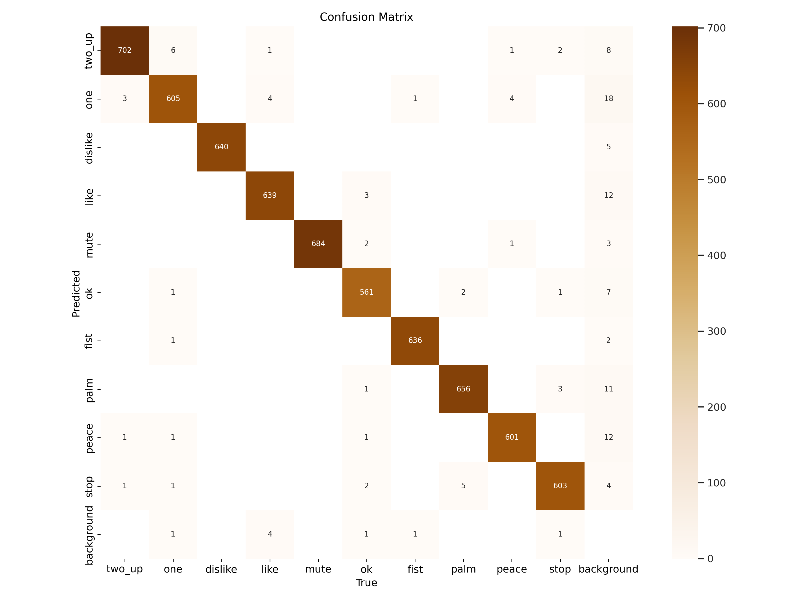

In [29]:
results('/content/drive/MyDrive/yolo_hand_detection/val/confusion_matrix.png')

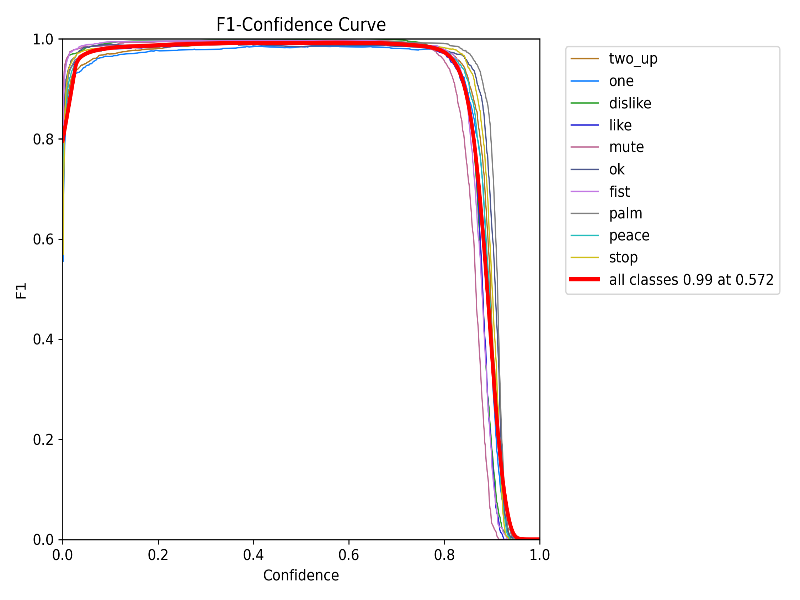

In [30]:
results('/content/drive/MyDrive/yolo_hand_detection/val/F1_curve.png')

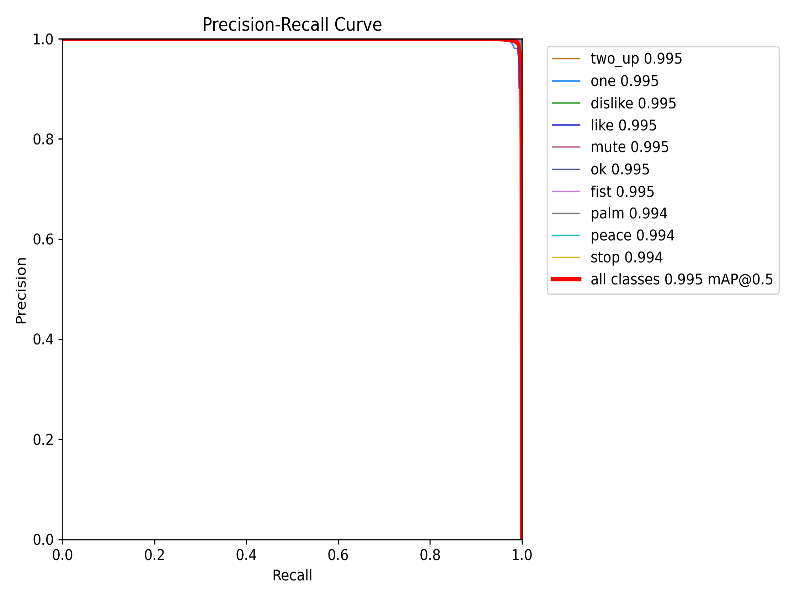

In [31]:
results('/content/drive/MyDrive/yolo_hand_detection/val/PR_curve.png')

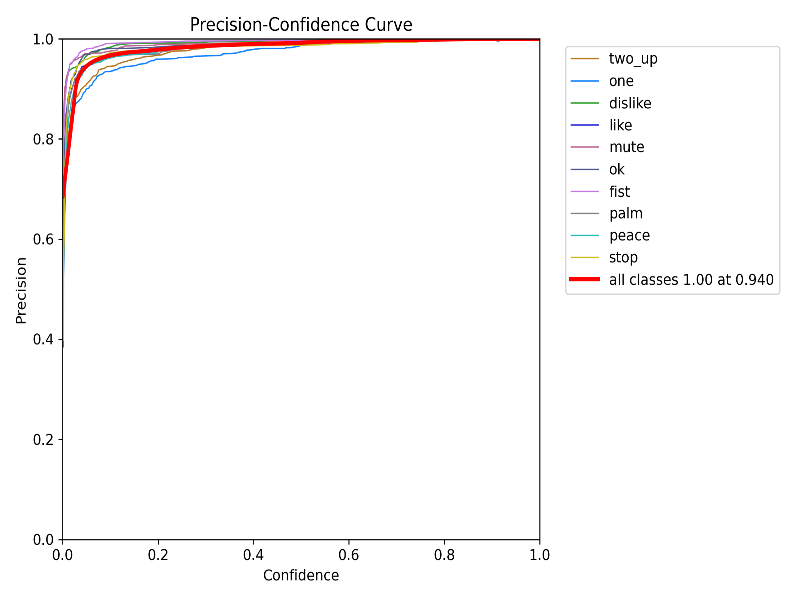

In [32]:
results('/content/drive/MyDrive/yolo_hand_detection/val/P_curve.png')

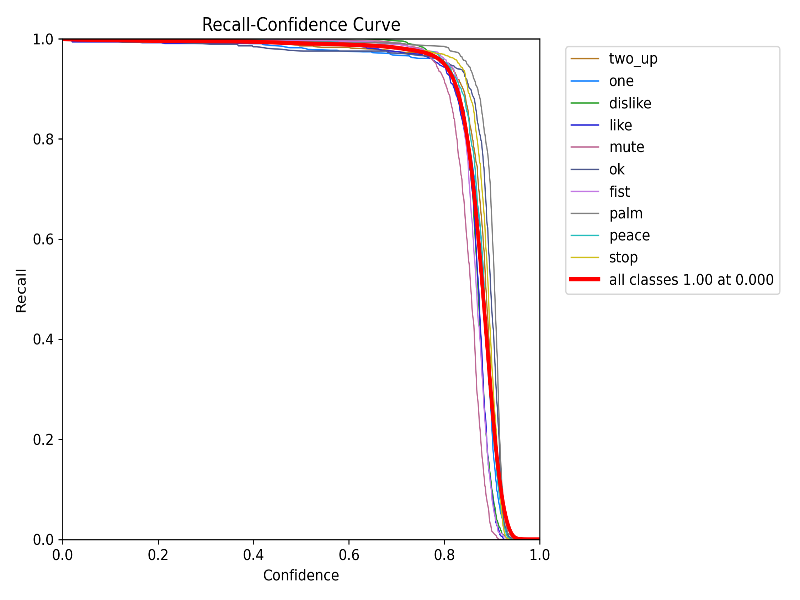

In [33]:
results('/content/drive/MyDrive/yolo_hand_detection/val/R_curve.png')

In [35]:
def draw_prediction(prediction):
  for r in prediction:
    boxes = r.boxes.xywhn.cpu().numpy()
    classes = r.boxes.cls.cpu().numpy()
    conf = r.boxes.conf.cpu().numpy()
    map = r.names
    img = r.orig_img
    if len(boxes) == 0:
      cv2_imshow(img)
    img_width, img_height = r.orig_shape
    box = boxes[np.argmax(conf)]
    label = map[classes[np.argmax(conf)]]
    conf = str(round(np.max(conf), 2))
    x = int(box[0] * img_height)
    y = int(box[1] * img_width)
    width = int(box[2] * img_height)
    height = int(box[3] * img_width)
    img = cv.rectangle(img, (int(x-width/2), int(y-height/2)), (int(x + width/2), int(y + height/2)), (0, 255, 0), 3)
    cv.putText(img, f'{label}:{conf}', (int(x-width/2), int(y-height/2)-10), cv.FONT_HERSHEY_SIMPLEX, 0.3, (36,255,12), 2)
    cv2_imshow(img)


image 1/1 /content/yolo/images/test/d8d6e0de-1f28-43e0-ae34-9f704d697405.jpg: 384x288 1 two_up, 95.1ms
Speed: 1.3ms preprocess, 95.1ms inference, 2.9ms postprocess per image at shape (1, 3, 384, 288)


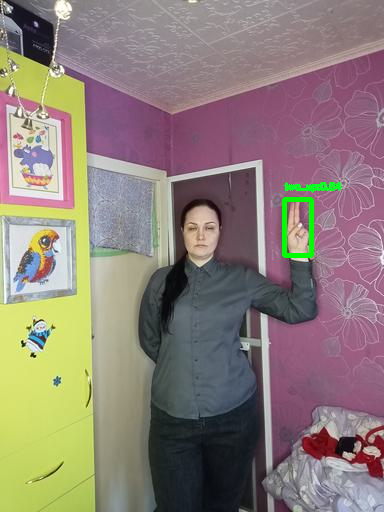


image 1/1 /content/yolo/images/test/d1932b24-0479-468d-ad52-b55da0c4abdd.jpg: 384x288 1 two_up, 13.7ms
Speed: 1.5ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 288)


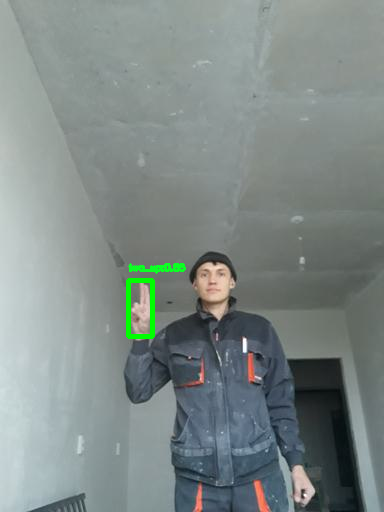


image 1/1 /content/yolo/images/test/67b61861-528f-472f-8583-d68e0bd18e27.jpg: 384x288 1 two_up, 10.8ms
Speed: 1.6ms preprocess, 10.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 288)


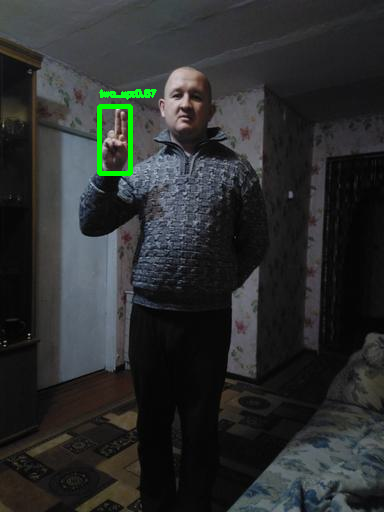


image 1/1 /content/yolo/images/test/5a33cd2a-a153-45f5-9e3c-1c0d5b6ec9e2.jpg: 384x288 1 two_up, 10.1ms
Speed: 1.5ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 288)


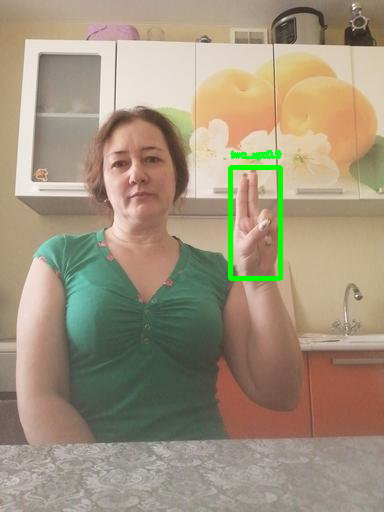


image 1/1 /content/yolo/images/test/cbc7c273-2909-4122-b7af-e56b7c4da51b.jpg: 384x288 1 mute, 10.7ms
Speed: 1.5ms preprocess, 10.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 288)


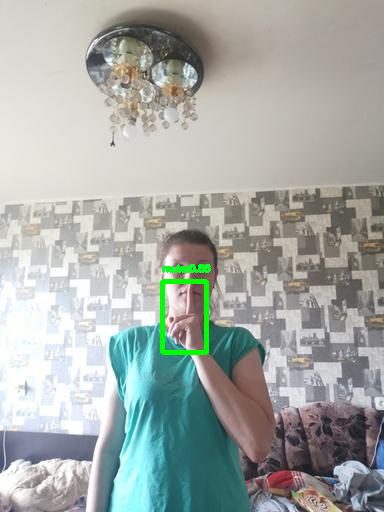


image 1/1 /content/yolo/images/test/c4a2198e-7b11-4d0f-a009-d1e18d6f644e.jpg: 384x288 1 one, 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 288)


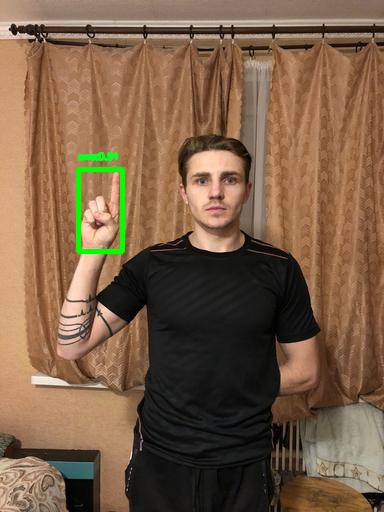


image 1/1 /content/yolo/images/test/e1e045d8-ec58-467f-b32a-68bad293cf61.jpg: 384x288 1 two_up, 13.7ms
Speed: 1.7ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 288)


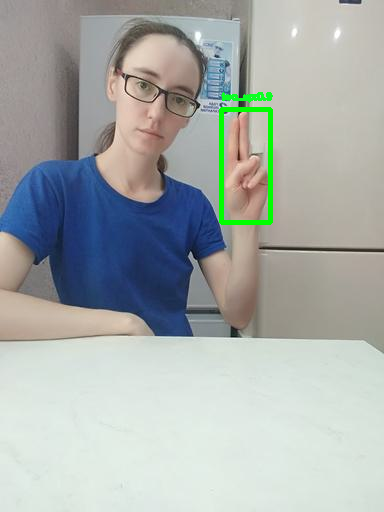


image 1/1 /content/yolo/images/test/81d59978-7ebb-4eea-9597-a86522dc3f5b.jpg: 224x384 1 stop, 93.9ms
Speed: 1.3ms preprocess, 93.9ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 384)


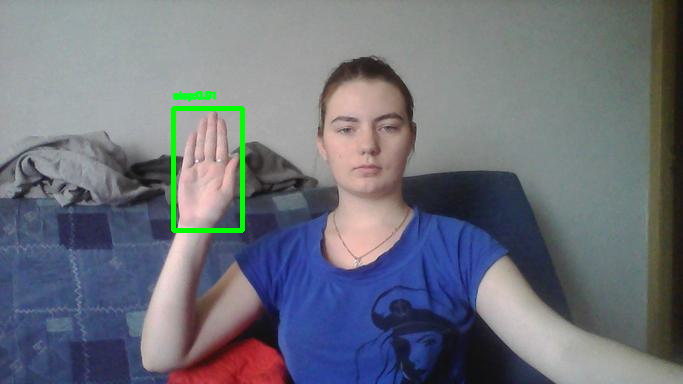


image 1/1 /content/yolo/images/test/90c0acf1-0731-4ea2-bfc0-663c2bb49099.jpg: 384x224 1 peace, 84.6ms
Speed: 1.7ms preprocess, 84.6ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 224)


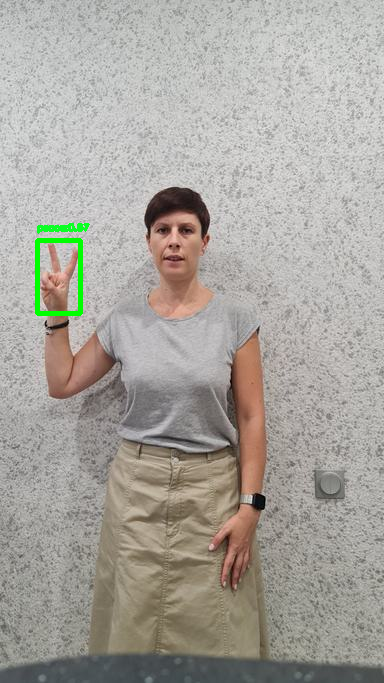


image 1/1 /content/yolo/images/test/13234cdd-774e-4142-adb2-819f61e08f2b.jpg: 384x288 1 mute, 11.1ms
Speed: 1.6ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 288)


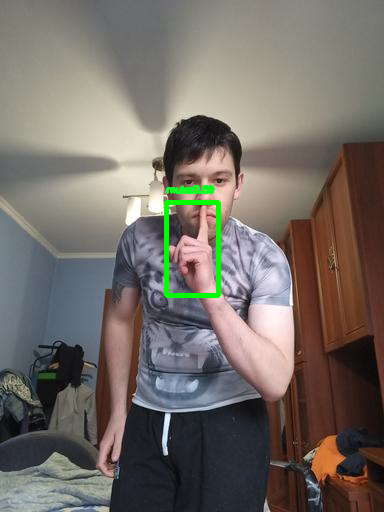

In [36]:
def random_predictions(num_of_pred):
  test_sample = test.sample(num_of_pred)
  for index, row in test_sample.iterrows():
    filepath = os.path.join('/content/yolo/images/test', row['filename']+'.jpg')
    prediction = model(filepath)
    draw_prediction(prediction)

random_predictions(10)